Found 2593 validated image filenames belonging to 4 classes.
Found 324 validated image filenames belonging to 4 classes.
Found 325 validated image filenames belonging to 4 classes.
Epoch 1/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 572s 5s/step - accuracy: 0.4546 - loss: 6.0563 - val_accuracy: 0.2438 - val_loss: 6.7302 - learning_rate: 1.0000e-04
Epoch 2/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 478s 6s/step - accuracy: 0.6864 - loss: 5.0885 - val_accuracy: 0.3364 - val_loss: 5.9195 - learning_rate: 1.0000e-04
Epoch 3/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 354s 4s/step - accuracy: 0.7590 - loss: 4.7003 - val_accuracy: 0.3735 - val_loss: 5.7314 - learning_rate: 1.0000e-04
Epoch 4/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 269s 3s/step - accuracy: 0.8008 - loss: 4.4593 - val_accuracy: 0.6265 - val_loss: 4.9505 - learning_rate: 1.0000e-04
Epoch 5/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 367s 4s/step - accuracy: 0.8732 - loss: 4.0838 - val_accuracy: 0.7685 - val_loss: 4.2621 - learning_rate: 1.0000e-04
Epoch 6/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 346s 4

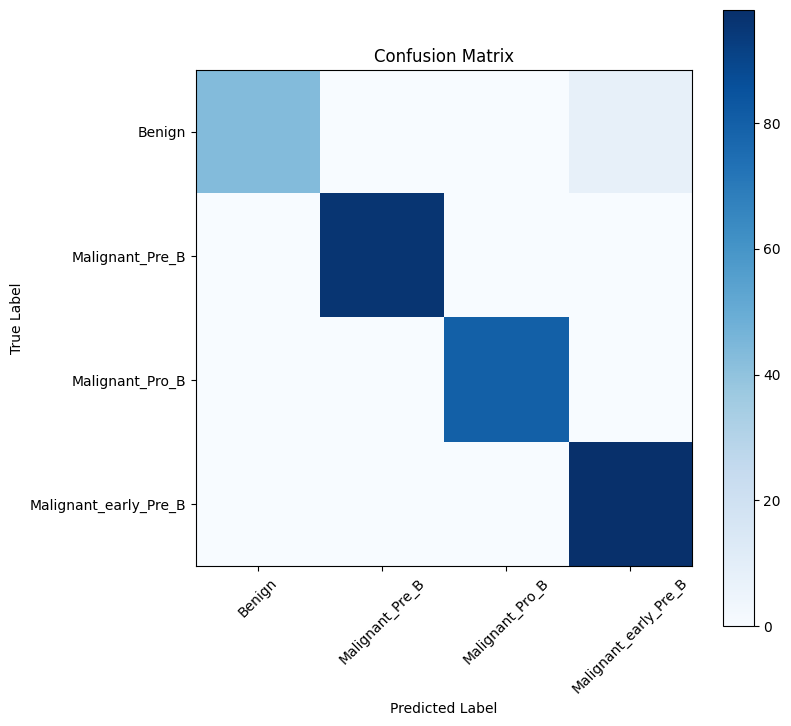

                       precision    recall  f1-score   support

               Benign       1.00      0.84      0.91        51
      Malignant_Pre_B       1.00      1.00      1.00        96
      Malignant_Pro_B       1.00      1.00      1.00        80
Malignant_early_Pre_B       0.92      1.00      0.96        98

             accuracy                           0.98       325
            macro avg       0.98      0.96      0.97       325
         weighted avg       0.98      0.98      0.97       325

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
Prediction: Malignant_Pre_B, Confidence: 54.43%


('Malignant_Pre_B', 54.43398356437683)

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

# Load Dataset Paths
data_dir = r'C:\Users\divya\Downloads\Blood cell Cancer [ALL]'
filepaths, labels = [], []

# Map Directories to Labels
label_map = {'Benign': 'Benign', 
             '[Malignant] Pre-B': 'Malignant_Pre_B', 
             '[Malignant] Pro-B': 'Malignant_Pro_B', 
             '[Malignant] early Pre-B': 'Malignant_early_Pre_B'}

for label_name, label_key in label_map.items():
    label_path = os.path.join(data_dir, label_name)
    files = os.listdir(label_path)
    for file in files:
        filepaths.append(os.path.join(label_path, file))
        labels.append(label_key)

# Create DataFrame
data_df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})

# Train-Test Split
train_df, dummy_df = train_test_split(data_df, train_size=0.8, stratify=data_df['labels'], random_state=123)
valid_df, test_df = train_test_split(dummy_df, train_size=0.5, stratify=dummy_df['labels'], random_state=123)

# Data Augmentation
img_size = (224, 224)
batch_size = 32
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1.0 / 255.0  # Normalize to [0,1]
)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

train_gen = train_datagen.flow_from_dataframe(
    train_df, x_col='filepaths', y_col='labels', 
    target_size=img_size, class_mode='categorical', batch_size=batch_size, shuffle=True
)
valid_gen = test_datagen.flow_from_dataframe(
    valid_df, x_col='filepaths', y_col='labels', 
    target_size=img_size, class_mode='categorical', batch_size=batch_size, shuffle=False
)
test_gen = test_datagen.flow_from_dataframe(
    test_df, x_col='filepaths', y_col='labels', 
    target_size=img_size, class_mode='categorical', batch_size=batch_size, shuffle=False
)

# Model Architecture
base_model = tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet", input_shape=(224, 224, 3), pooling='max')
base_model.trainable = True

for layer in base_model.layers[:100]:  # Freeze first 100 layers
    layer.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(len(train_gen.class_indices), activation='softmax')
])

# Compile Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-7, verbose=1)

# Train Model
history = model.fit(train_gen, epochs=20, validation_data=valid_gen, callbacks=[early_stopping, reduce_lr], verbose=1)

# Evaluate Model
test_loss, test_accuracy = model.evaluate(test_gen)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Confusion Matrix
y_true = test_gen.classes
y_pred = np.argmax(model.predict(test_gen), axis=-1)
cm = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(range(len(train_gen.class_indices)), list(train_gen.class_indices.keys()), rotation=45)
plt.yticks(range(len(train_gen.class_indices)), list(train_gen.class_indices.keys()))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=list(train_gen.class_indices.keys())))

# Save Model
model.save('blood_cancer_model.h5')

# Prediction Function
def predict_image(img_path):
    img = tf.keras.utils.load_img(img_path, target_size=img_size)
    img_array = tf.keras.utils.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    predicted_class = list(train_gen.class_indices.keys())[np.argmax(prediction)]
    confidence = np.max(prediction) * 100
    print(f"Prediction: {predicted_class}, Confidence: {confidence:.2f}%")
    return predicted_class, confidence

# Example Predictions
example_image_path = r"C:\Users\divya\OneDrive\Desktop\BCD\blood_sample.jpeg"
predict_image(example_image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
Prediction: Malignant_Pre_B, Confidence: 99.95%
Combined Malignant Confidence: 100.00%
Cancer Status: Cancer Detected
Cancer Stage: Stage 4


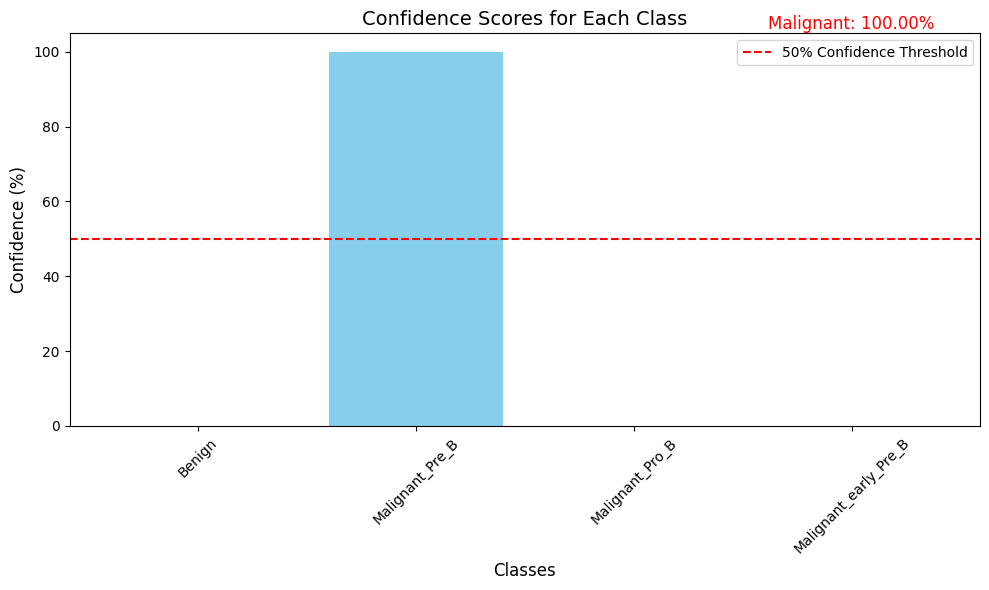

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
Prediction: Malignant_Pro_B, Confidence: 100.00%
Combined Malignant Confidence: 100.00%
Cancer Status: Cancer Detected
Cancer Stage: Stage 4


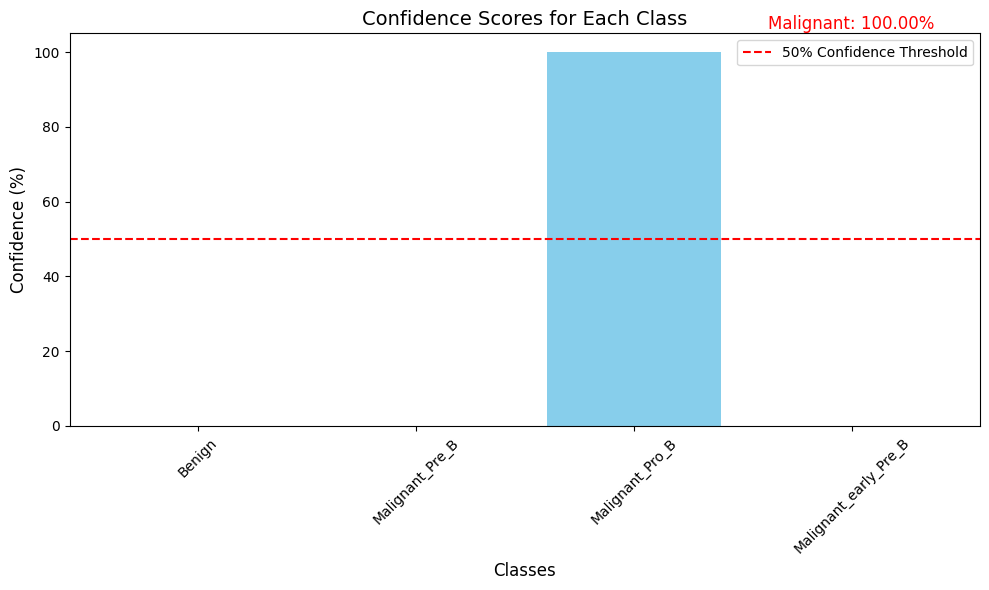

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
Prediction: Malignant_early_Pre_B, Confidence: 41.27%
Combined Malignant Confidence: 80.46%
Cancer Status: Cancer Detected
Cancer Stage: Stage 4


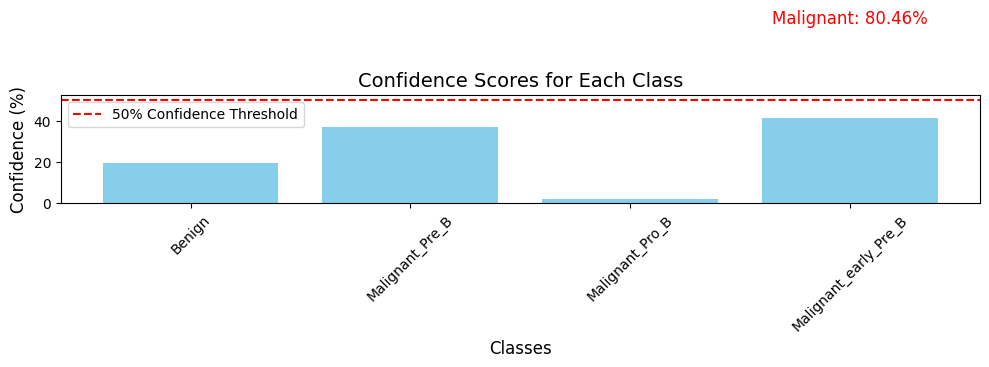

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
Prediction: Malignant_early_Pre_B, Confidence: 99.43%
Combined Malignant Confidence: 99.49%
Cancer Status: Cancer Detected
Cancer Stage: Stage 4


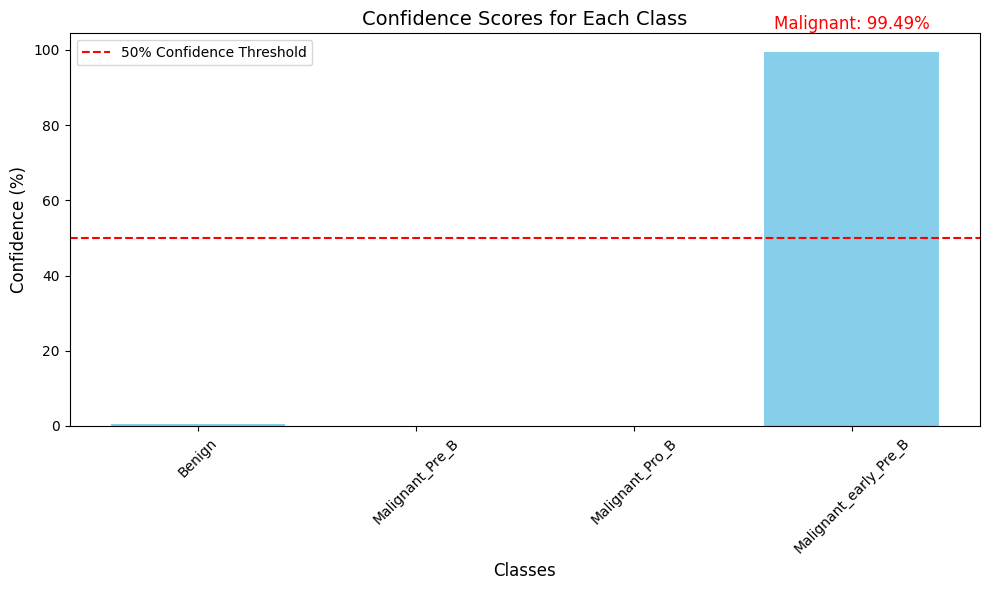

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
Prediction: Malignant_Pre_B, Confidence: 54.43%
Combined Malignant Confidence: 80.09%
Cancer Status: Cancer Detected
Cancer Stage: Stage 4


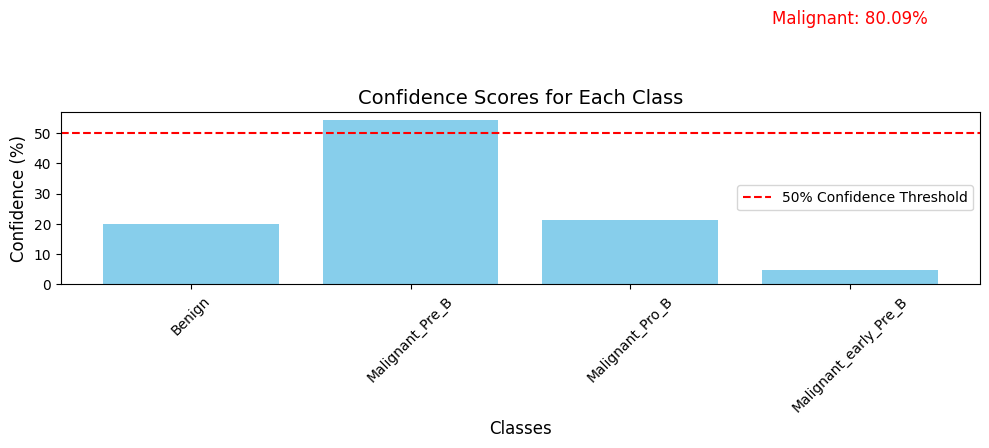

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
Prediction: Benign, Confidence: 99.75%
Combined Malignant Confidence: 0.25%
Cancer Status: Cancer Detected
Cancer Stage: Stage 1


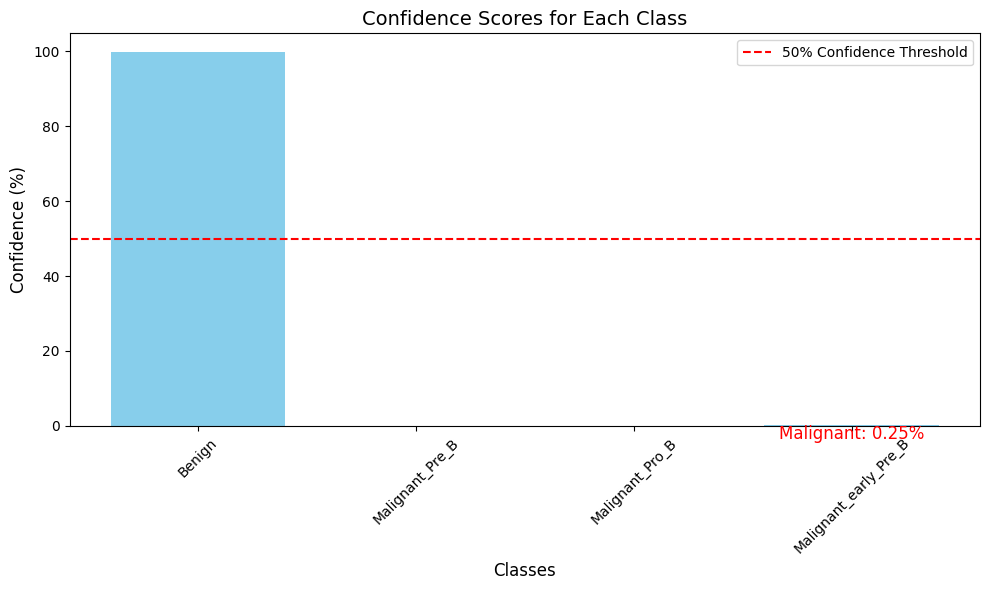

In [16]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

# Updated Prediction Function with Combined Confidence Scores
def predict_cancer_with_combined_scores(img_path):
    # Load and preprocess the image
    img = tf.keras.utils.load_img(img_path, target_size=img_size)
    img_array = tf.keras.utils.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict the class and get confidence scores
    prediction = model.predict(img_array)
    confidence_scores = prediction[0]
    predicted_class = list(train_gen.class_indices.keys())[np.argmax(confidence_scores)]
    confidence = np.max(confidence_scores) * 100

    # Aggregate confidence score for cancer stages
    malignant_indices = [i for i, cls in enumerate(train_gen.class_indices.keys()) if 'Malignant' in cls]
    malignant_score = sum([confidence_scores[i] for i in malignant_indices]) * 100

    # Determine cancer presence and stage based on combined scores
    if malignant_score > 0:
        cancer_status = "Cancer Detected"
        if malignant_score >= 75:
            cancer_stage = "Stage 4"
        elif malignant_score >= 50:
            cancer_stage = "Stage 3"
        elif malignant_score >= 25:
            cancer_stage = "Stage 2"
        else:
            cancer_stage = "Stage 1"
    else:
        cancer_status = "No Cancer Detected"
        cancer_stage = "N/A"

    # Print Prediction and Stage
    print(f"Prediction: {predicted_class}, Confidence: {confidence:.2f}%")
    print(f"Combined Malignant Confidence: {malignant_score:.2f}%")
    print(f"Cancer Status: {cancer_status}")
    if cancer_status == "Cancer Detected":
        print(f"Cancer Stage: {cancer_stage}")

    # Plot Confidence Scores
    classes = list(train_gen.class_indices.keys())
    plt.figure(figsize=(10, 6))

    # Plotting all classes (including those with 0 confidence)
    plt.bar(classes, confidence_scores * 100, color='skyblue')

    # Adjusting the plot for better presentation
    plt.xlabel('Classes', fontsize=12)
    plt.ylabel('Confidence (%)', fontsize=12)
    plt.title('Confidence Scores for Each Class', fontsize=14)
    plt.xticks(rotation=45, fontsize=10)

    # Ensure all classes are visible, even if some have zero confidence
    plt.axhline(y=50, color='red', linestyle='--', label='50% Confidence Threshold')

    # Adjust label position for malignant confidence score to avoid collision with 50% line
    label_position = malignant_score
    if malignant_score >= 50:
        label_position += 5  # Shift label above the bar if score is close to or above 50%
    elif malignant_score < 50 and malignant_score > 20:
        label_position -= 5  # Shift label below if score is between 20% and 50%
    # Add a label specifically for malignant scores
    if malignant_score > 0:
        plt.text(len(classes) - 1, label_position, f'Malignant: {malignant_score:.2f}%', 
                 color='red', fontsize=12, ha='center', va='bottom' if malignant_score >= 50 else 'top')

    plt.legend()
    plt.tight_layout()
    plt.show()

    return predicted_class, confidence, cancer_status, cancer_stage

# Example Prediction
example_image_paths = [
    r"C:\Users\divya\OneDrive\Desktop\BCD\Snap_776.jpg",
    r"C:\Users\divya\OneDrive\Desktop\BCD\Snap_765.jpg",
    r"C:\Users\divya\OneDrive\Desktop\BCD\Snap_158jpg.jpg",
    r"C:\Users\divya\OneDrive\Desktop\BCD\Snap_1586.jpg",
    r"C:\Users\divya\OneDrive\Desktop\BCD\blood_sample.jpeg",
    r"C:\Users\divya\OneDrive\Desktop\BCD\Snap_156.jpg"
]

for img_path in example_image_paths:
    predict_cancer_with_combined_scores(img_path)
